In [107]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

import pmdarima.arima
from pmdarima.arima.utils import ndiffs

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}",)

Using cuda


### Prepare time series

In [4]:
df = pd.read_csv('../data/paris_temperature.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(df['datetime'])
temp = df['temp']
temp.head(10)

datetime
2023-10-01    18.9
2023-10-02    20.7
2023-10-03    18.8
2023-10-04    14.2
2023-10-05    14.7
2023-10-06    14.7
2023-10-07    16.7
2023-10-08    18.5
2023-10-09    18.9
2023-10-10    18.9
Name: temp, dtype: float64

### Analysis

In [47]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
    adf_result = adfuller(ts)

    # Output the results
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
        
    if adf_result[1] < 0.05:
        print("Time series is stationary.")
    else:
        print("Time series is non-stationary.")

adf_test(temp)

ADF Statistic: -2.742622887630039
p-value: 0.06694856335880962
Time series is non-stationary.


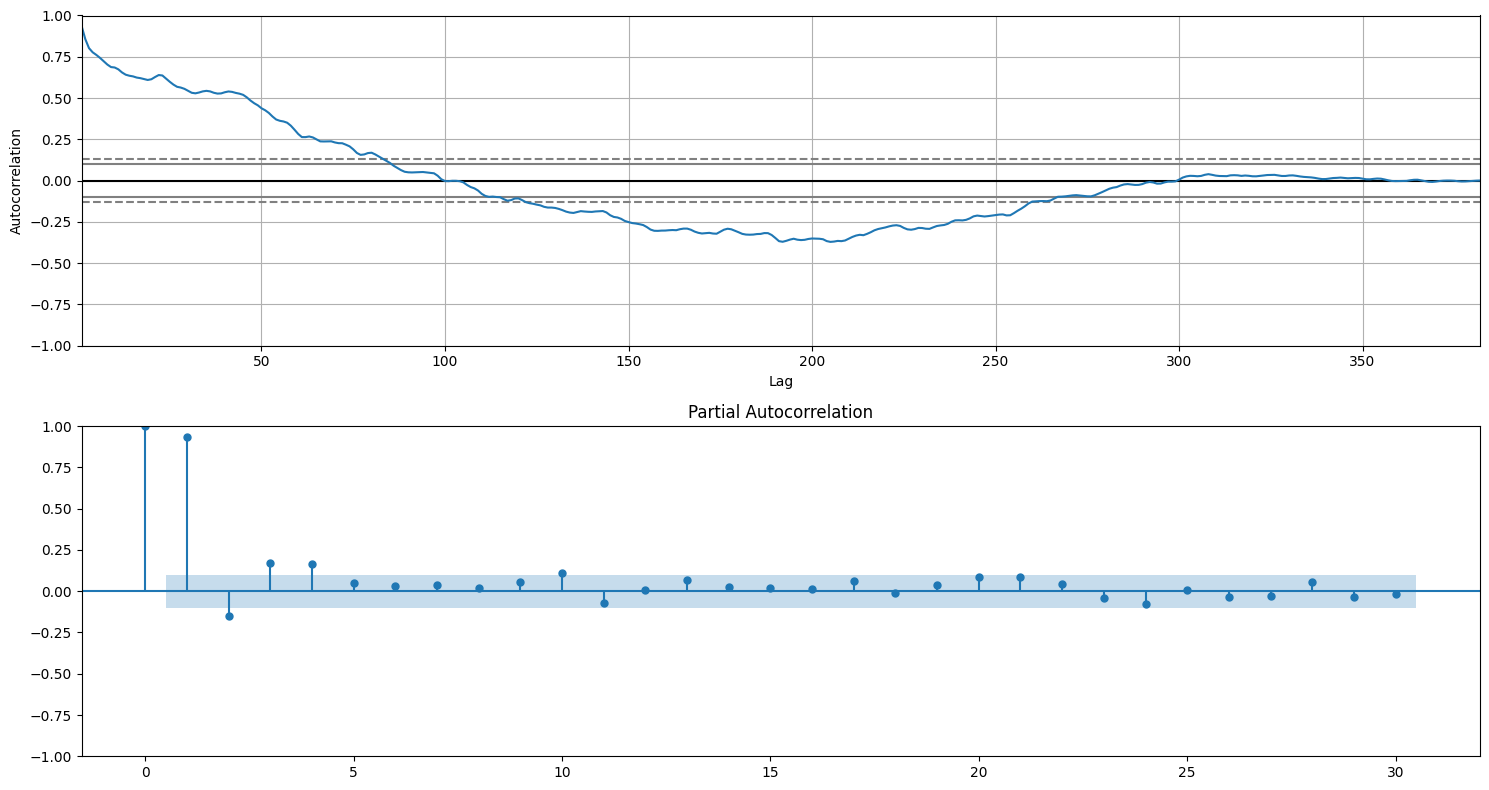

In [71]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(2,1,1)
pd.plotting.autocorrelation_plot(temp)

ax = fig.add_subplot(2,1,2)
plot_pacf(temp,ax = ax, method='ywm', lags=30)
plt.tight_layout()
plt.show()

In [50]:
print(f"Differencing order: {ndiffs(temp, test='adf')}")

Differencing order: 1


### Split train test set

In [6]:
train = temp[temp.index <= pd.to_datetime('2024/09/15')]
test = temp[temp.index > pd.to_datetime('2024/09/15')]
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (351,)
Test: (31,)


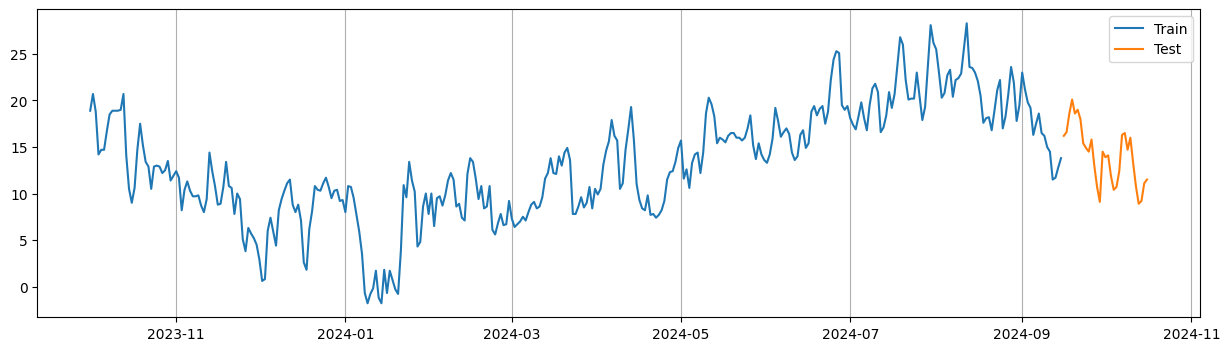

In [7]:
fig = plt.figure(figsize=(15,4))

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.gca().xaxis.grid()
plt.legend()

### Normalize data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train.to_frame())

train_normalized = scaler.transform(train.values.reshape(-1, 1))
test_normalized = scaler.transform(test.values.reshape(-1,1))

/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/dangnh/b3/time-series/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [9]:
train_normalized = pd.Series(np.squeeze(train_normalized), index=train.index)
test_normalized = pd.Series(np.squeeze(test_normalized), index=test.index)

### Prepare dataset using time delay embedding

In [10]:
class ParisTemperatureTimeDelayEmbedding:
    def __init__(self, ts, lags):
        # self.dataset = dataset
        self.ts = ts
        self.lags = lags

    def __getitem__(self, idx: int):
        new_df = pd.DataFrame({'target':self.ts})
        
        for i in range(self.lags):
            shift_temp = self.ts.shift(i+1).rename(f"lag{i+1}")
            new_df = pd.concat([new_df, shift_temp], axis=1)

        new_df = new_df.dropna()

        targets = new_df['target']
        features = new_df.drop('target', axis=1)

        targets = torch.from_numpy(targets.values)
        features = torch.from_numpy(features.values)

        return features[idx, :].to(torch.float), targets[idx].to(torch.float)


    def __len__(self):
        return self.ts.shape[0] - self.lags

In [81]:
lags = 1

train_dataset = ParisTemperatureTimeDelayEmbedding(train_normalized, lags=lags)
test_dataset = ParisTemperatureTimeDelayEmbedding(test_normalized, lags=lags)

In [83]:
batch = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

### Define model

In [84]:
class LstmOneHorizon(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size1 = 50
        self.lstm1 = nn.LSTM(input_size = 1, hidden_size= hidden_size1, num_layers=1, batch_first=True)
        self.regressor = nn.Linear(in_features=50, out_features=1)

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        x = self.regressor(x)

        return x.squeeze()


In [42]:
model = LstmOneHorizon().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

----------------------------------------------------------------------------------------------------
EPOCH [1/100]
Loss: 0.11172412903132764
Train loss: 0.11172412903132764, Validation loss: 0.06924831122159958
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [2/100]
Loss: 0.0638598435325548
Train loss: 0.0638598435325548, Validation loss: 0.025814570486545563
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [3/100]
Loss: 0.050660439978607676
Train loss: 0.050660439978607676, Validation loss: 0.012676928425207734
New best model found
----------------------------------------------------------------------------------------------------
EPOCH [4/100]
Loss: 0.04910581609742208
Train loss: 0.04910581609742208, Validation loss: 0.010702923173084855
New best model found
---------------------------------------------------------------------

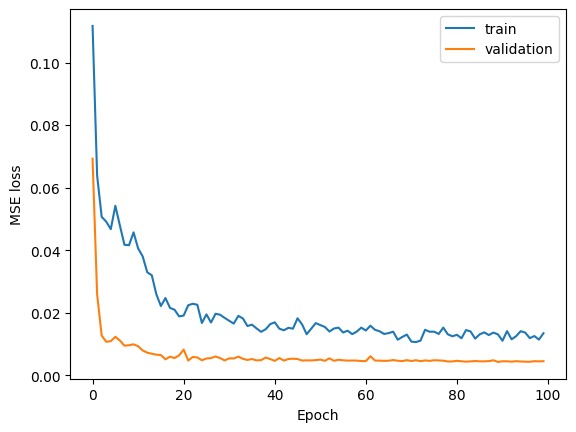

In [43]:
epochs = 100
train_loss = []
test_loss = []
train_rmse = []
val_rmse = []
best_test_loss = 10000


for epoch in range(epochs):
    print('-' * 100)
    print(f'EPOCH [{epoch+1}/{epochs}]')


    model.train()
    loss_train_batch = 0 
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_train_batch += loss.item()
    
    train_loss.append(loss_train_batch/len(train_dataloader))
    print(f'Loss: {loss_train_batch/len(train_dataloader)}')


    model.eval()
    loss_val_batch = 0
    with torch.no_grad():
        for i, (features, target) in enumerate(test_dataloader):
            features = features.to(device).unsqueeze(2)
            target = target.to(device)

            output = model(features)
            vloss = loss_fn(output, target)

            loss_val_batch += vloss.item()

    test_loss.append(loss_val_batch/len(test_dataloader))
    print(f'Train loss: {loss_train_batch/len(train_dataloader)}, Validation loss: {loss_val_batch/len(test_dataloader)}')

    if (loss_val_batch < best_test_loss):
        best_test_loss = loss_val_batch
        print("New best model found")
        torch.save(model.state_dict(), f'../model/temp_norm_LstmMlp_ts{lags}_b{batch}.pth')


plt.plot(np.arange(len(train_loss), dtype=int), train_loss, label='train')
plt.plot(np.arange(len(test_loss), dtype=int), test_loss, label= 'validation')
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()



### Test model

In [85]:
# model = LstmOneHorizon().to(device)
# model.load_state_dict(torch.load('../model/temp_norm_lstm_ts1_b16.pth'))

/tmp/ipykernel_7258/968675008.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model/temp_norm_lstm_ts1_b16.pth'))


<All keys matched successfully>

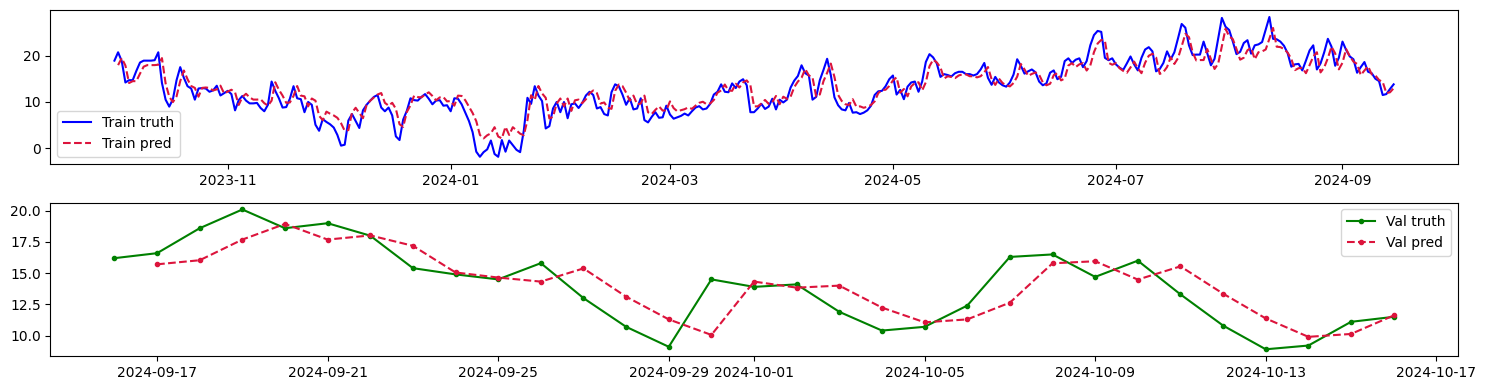

In [105]:
train_outputs = []
test_outputs = []
model.eval()
with torch.no_grad():
    for i, (features, target) in enumerate(train_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features).cpu().tolist()
        train_outputs += output
        

    for i, (features, target) in enumerate(test_dataloader):
        features = features.to(device).unsqueeze(2)
        target = target.to(device)

        output = model(features).cpu().tolist()
        test_outputs += output

train_outputs = np.array(train_outputs).reshape(-1,1)
test_outputs = np.array(test_outputs).reshape(-1,1)


train_outputs = scaler.inverse_transform(train_outputs)
test_outputs = scaler.inverse_transform(test_outputs)

train_outputs = pd.Series(np.squeeze(train_outputs), index=train.index[lags:])
test_outputs = pd.Series(np.squeeze(test_outputs), index=test.index[lags:])

fig = plt.figure(figsize=(15,4))

fig.add_subplot(2,1,1)
plt.plot(train, label='Train truth', color='blue')
plt.plot(train_outputs,color='crimson', linestyle = 'dashed', label='Train pred')
plt.legend()


fig.add_subplot(2,1,2)
plt.plot(test, color='green', label='Val truth', marker='.')
plt.plot(test_outputs,color = 'crimson', linestyle = 'dashed',marker='.', label='Val pred')
plt.legend()

plt.tight_layout()


In [ ]:
print(f"RMSE: {root_mean_squared_error(test[lags:], test_outputs)}")
print(f"R2: {r2_score(test[lags:], test_outputs)}")
print(f"MAPE: {mean_absolute_percentage_error(test[lags:], test_outputs)}")

RMSE: 1.851822186125836
R2: 0.6464715702515929
MAPE: 0.11388167369854225


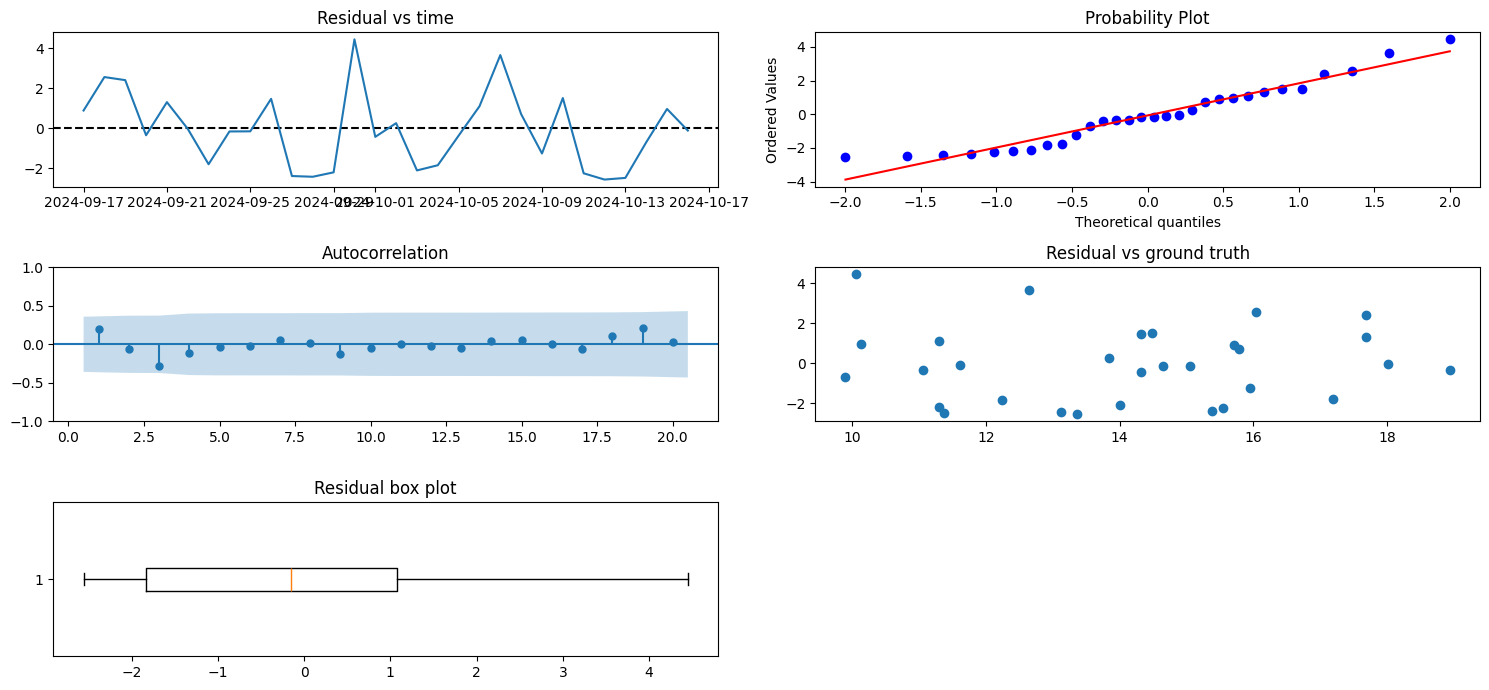

In [136]:
residuals = test[lags:] - test_outputs 
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(3,2,1)
plt.axhline(0, color='k', linestyle='dashed')
plt.plot(residuals)
plt.title("Residual vs time")

fig.add_subplot(3,2,2)
stats.probplot(residuals, dist="norm", plot=plt)

ax = fig.add_subplot(3,2,3)
plot_acf(residuals, lags=20, ax=ax, zero=False)

fig.add_subplot(3,2,4)
plt.scatter(test_outputs, residuals)
plt.title("Residual vs ground truth")

fig.add_subplot(3,2,5)
plt.boxplot(residuals, vert=False)
plt.title("Residual box plot")

plt.tight_layout()

In [127]:
adf_test(residuals)

ADF Statistic: -4.291604401430666
p-value: 0.00045932026184027726
Time series is stationary.
